In [2]:
import numpy as np
import matplotlib.font_manager as fm
import gensim
myfont = fm.FontProperties(fname='/home/disk3/luqi03/notebook/simhei.ttf')
from matplotlib import pyplot as plt
import matplotlib
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn
import sklearn.datasets
import sklearn.linear_model
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

## 词向量
+ **one hot vector**：对每个词用0-1向量$\Re^{|V|*1}$来表示。其中$V$表示词表的大小。这种表示形式，词于词之间相互独立。所以一个直观的想法是通过加减少向量的维度来得到词于词之间的关系

### 基于SVD的方法 (Singular Value Decomposition)
这个方法的原理是我们遍历每个document，然后统计词于词之间共现的次数，形成一个共现次数矩阵$X$，然后对矩阵$X$进行奇异值分解，得到$USV^{T}$，我们使用$U$当做word vector。
#### Window based Co-occurrence Matrix
+ **Word-Document Matrix**：计算共现的时候只计算一个固定窗口大小的共现次数。
+ 例子：
    + I like deep learning.
    + I like NLP.
    + I enjoy flying.
+ 假设窗口为1，那么共现矩阵$X$就是：

| counts | I  | like | enjoy | deep | learning | NLP | flying | . |         
| :-: | :-: |:-: |:-: |:-: |:-: |:-: |:-: |:-: |
| I | 0 | 2 | 1 | 0 | 0 | 0 | 0 | 0 |
| like | 2 | 0 | 0 | 1 | 0 | 1 | 0 | 0 |
| enjoy | 1 | 2 | 1 | 0 | 0 | 0 | 1 | 0 |
| deep | 0 | 1 | 0 | 0 | 1 | 0 | 0 | 0 |
| learning | 0 | 0 | 0 | 1 | 0 | 0 | 0 | 1 |
| NLP | 0 | 1 | 0 | 0 | 0 | 0 | 0 | 1 |
| flying | 0 | 0 | 1 | 0 | 0 | 0 | 0 | 1 |
| . | 0 | 0 | 0 | 0 | 1 | 1 | 1 | 0 |

对上面这个表格进行SVD运算。

In [10]:
la = np.linalg
words = ["I", "like", "enjoy", "deep", "learning", "NLP", "flying", "."]
X = np.array([[0,2,1,0,0,0,0,0],
             [2,0,0,1,0,1,0,0],
             [1,0,0,0,0,0,1,0],
             [0,1,0,0,1,0,0,0],
             [0,0,0,1,0,0,0,1],
             [0,1,0,0,0,0,0,1],
             [0,0,1,0,0,0,0,1],
             [0,0,0,0,1,1,1,0]])
U, s, Vh = la.svd(X, full_matrices=False)

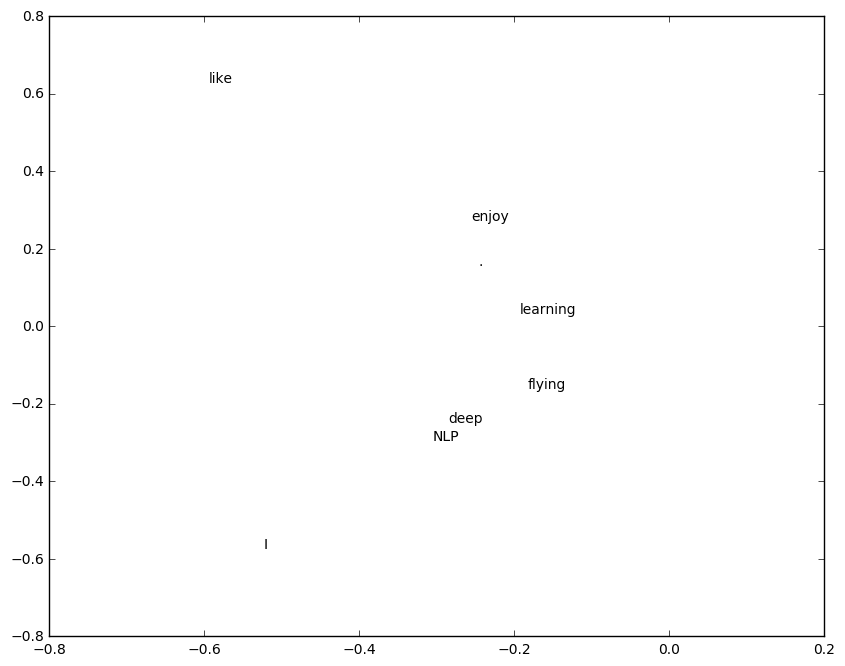

In [11]:
plt.axis([-0.8, 0.2, -0.8, 0.8])
for i in range(len(words)):
    plt.text(U[i,0], U[i,1], words[i])
plt.show()

#### 上述的方法会遇到以下几个问题
+ 维数过高，并且会经常改变（新增words，和预料）
+ 矩阵非常稀疏，因为大多数词之间都不会共现
+ 训练时间非常长

In [5]:
model = gensim.models.Word2Vec.load("wikipedia/model/wiki.en.model")

In [6]:
def vector_similar(vec1, vec2):
    l1 = np.sqrt(vec1.dot(vec1))
    l2 = np.sqrt(vec2.dot(vec2))
    return vec1.dot(vec2) / (l1 * l2)

In [7]:
model.most_similar("queen")

[(u'princess', 0.6531424522399902),
 (u'king', 0.636505663394928),
 (u'empress', 0.5884059071540833),
 (u'monarch', 0.5316866636276245),
 (u'pxqueen', 0.5047897100448608),
 (u'kosmetatou', 0.49346214532852173),
 (u'goudge', 0.48928824067115784),
 (u'duchess', 0.48848432302474976),
 (u'geierstein', 0.4873059093952179),
 (u'regent', 0.4837557077407837)]

In [8]:
model.most_similar("man")

[(u'woman', 0.6952337026596069),
 (u'boy', 0.6095595359802246),
 (u'girl', 0.5981869697570801),
 (u'person', 0.5264346599578857),
 (u'stranger', 0.5090831518173218),
 (u'thug', 0.48483434319496155),
 (u'drunkard', 0.48466727137565613),
 (u'swordsman', 0.4822547435760498),
 (u'warrior', 0.47220751643180847),
 (u'policeman', 0.47136062383651733)]

In [9]:
vector_similar(model["king"] - model["man"], model["queen"] - model["woman"])

0.68212205

In [10]:
vector_similar(model["girls"] - model["girl"], model["boys"] - model["boy"])

0.78013426

In [11]:
vector_similar(model["girl"], model["girls"])

0.65006739

In [14]:
vector_similar(model["machine"], model["learning"])

0.093335241

In [15]:
model = gensim.models.Word2Vec.load("./scholar_intent_detection/word2vec/model/paper_zh.model")

In [16]:
def get_similar(word):
    word = word.decode("utf-8")
    for w in model.most_similar(word):
        yield w[0]

In [17]:
def print_similar(word):
    word = word.decode("utf-8")
    for w in model.most_similar(word):
        print w[0]

In [19]:
print_similar("计算机")

计算机系统
计算机网络
计算机技术
计算机软件
电子计算机
微机
电脑
计算机硬件
软件技术
算机


In [20]:
words = list(get_similar("计算机")) + list(get_similar("生物")) + \
    list(get_similar("化学")) + list(get_similar("人文")) + list(get_similar("美术"))

In [21]:
rows = [model[word] for word in words]    

In [25]:
def draw_words(model, words, pca=False, alternate=True, x1=3, x2=3, y1=3, y2=3, title=''):
    vectors = [model[word] for word in words]
    if pca:
        pca = PCA(n_components=2, whiten=True)
        vectors2d = pca.fit(vectors).transform(vectors)
    else:
        tsne = TSNE(n_components=2, random_state=3)
        vectors2d = tsne.fit_transform(vectors)
    plt.figure(figsize=(6,6))
    if pca:
        plt.axis([x1, x2, y1, y2])
    first = True
    for point, word in zip(vectors2d , words):
        plt.scatter(point[0], point[1], c='r' if first else 'g')
        plt.annotate(
            word, 
            xy = (point[0], point[1]),
            xytext = (-7, -6) if first else (7, -6),
            textcoords = 'offset points',
            ha = 'right' if first else 'left',
            va = 'bottom',
            size = "x-small",
            fontproperties = myfont
        )
        first = not first if alternate else first
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

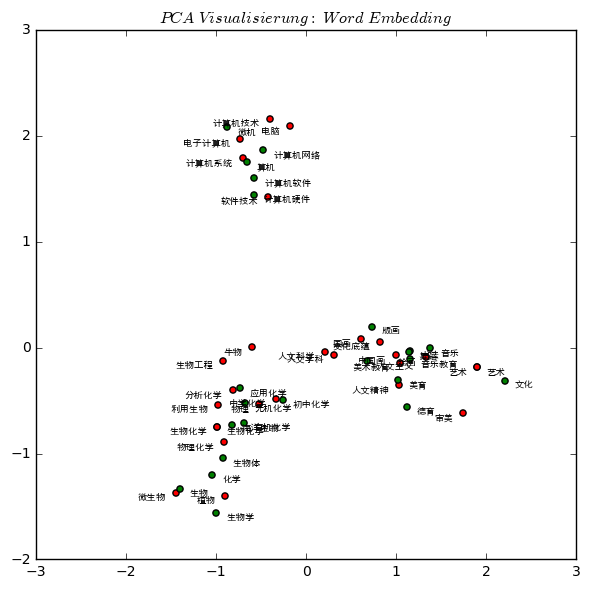

In [26]:
draw_words(model, words, True, True, -3, 3, -2, 3, r'$PCA\ Visualisierung:\ Word\ Embedding$')

#### 语言模型 (Unigram, Bigram, Trigram, etc.)
+ **目标**：学习一个概率函数，可以表示任意一个词序列的概率。
+ **难点**：维数灾难(*curse of dimensionality*)。


对于一句话（词序列），我可以定义这个词序列的概率为：$P(w_1,w_2,\dots,w_n)$

+ **一元语言模型(Unigram Model)**，我们假设所有的词出现的概率是相互独立的，那么：$P(w_1,w_2,\dots,w_n)=\prod_{i=1}^{n}P(w_i)$
+ **二元语言模型(Bigram Model)**，显然词于词之间不是相互独立的，我们可以假设词序列的概率是由每个词和这个词前面一个词的成对概率$P(w_i|w_{i-1})$得到，那么：$P(w_1,w_2,\dots,w_n)=\prod_{i=2}^{n}P(w_i|w_{i-1})$
+ **三元语言模型(Trigram Model)**，和Bigram类似，$P(w_1,w_2,\dots,w_n)=\prod_{i=3}^{n}P(w_i|w_{i-1},w_{i-2})$

### 神经网络
#### 激活函数
$sigmoid(x)=\frac{1}{1+e^{-x}}$
#### 感知机
+ 感知机的形式：一个输入层，一个输出层，$y=sigmoid(\sum_{i}w_{i}x_{i}-\theta)$
+ 感知机无法处理线性不可分问题。
+ 增加一个隐含层。

#### 误差逆传播算法 (error BackPropagation)
+ **Error Fuction**：$E_k = \frac{1}{2}\sum_{j=1}^{l}(\gamma_{j}^{k}-y_{j}^{k})_{2}$
+ 具体推导没仔细看。。。有兴趣的可以看一看。大概是通过梯度下降的方法。

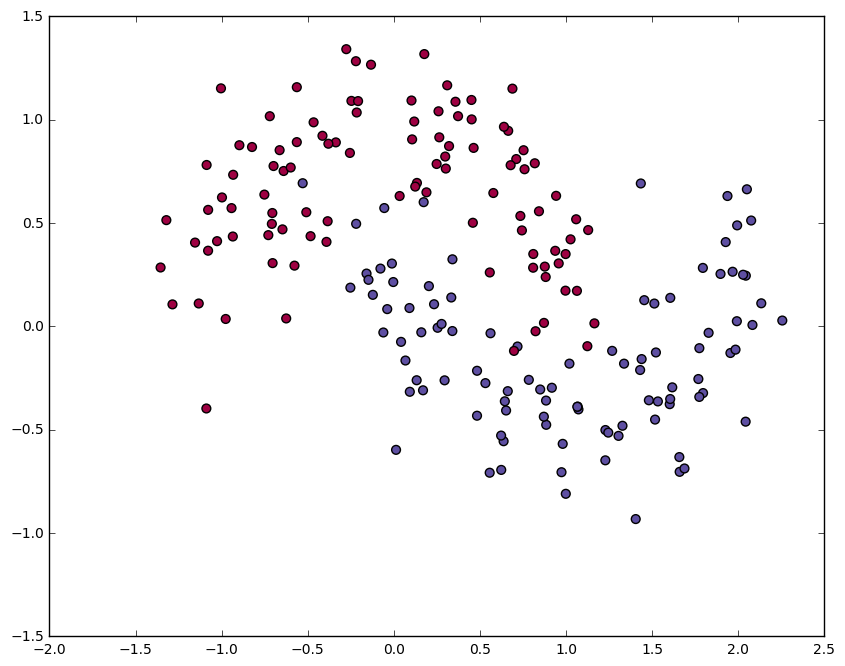

In [3]:
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

In [4]:
clf = sklearn.linear_model.LogisticRegressionCV(n_jobs=4)
clf.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=4, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [5]:
def plot_decision_boundary(pred_func):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

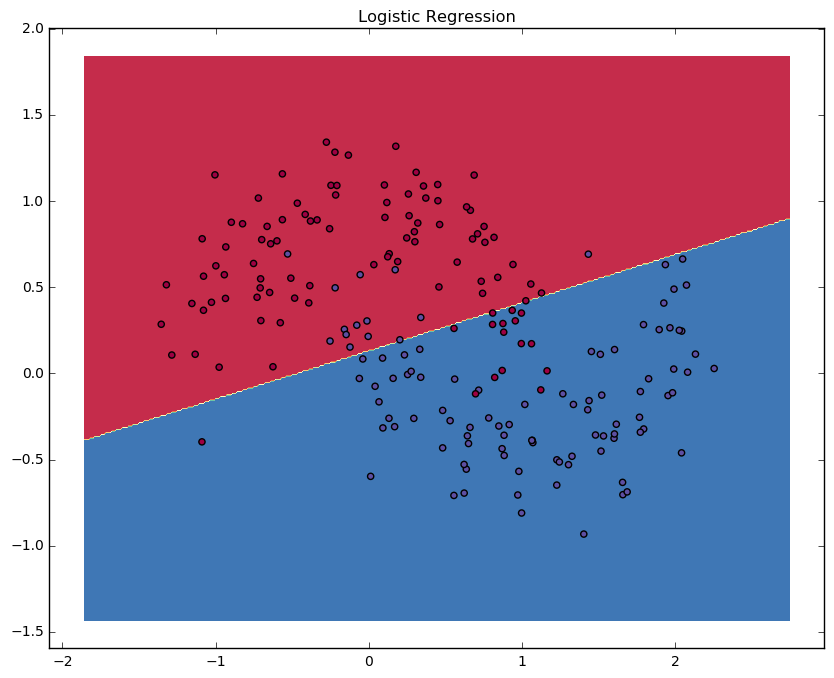

In [6]:
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

In [7]:
num_examples = len(X)
nn_input_dim = 2
nn_output_dim = 2
epsilon = 0.01
reg_lambda = 0.01

def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

def build_model(nn_hdim, num_passes=20000, print_loss=False):
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
    model = {}
    for i in xrange(0, num_passes):
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        if print_loss and i % 1000 == 0:
          print "Loss after iteration %i: %f" %(i, calculate_loss(model))
    return model

Loss after iteration 0: 0.432387
Loss after iteration 1000: 0.068947
Loss after iteration 2000: 0.068926
Loss after iteration 3000: 0.071218
Loss after iteration 4000: 0.071253
Loss after iteration 5000: 0.071278
Loss after iteration 6000: 0.071293
Loss after iteration 7000: 0.071303
Loss after iteration 8000: 0.071308
Loss after iteration 9000: 0.071312
Loss after iteration 10000: 0.071314
Loss after iteration 11000: 0.071315
Loss after iteration 12000: 0.071315
Loss after iteration 13000: 0.071316
Loss after iteration 14000: 0.071316
Loss after iteration 15000: 0.071316
Loss after iteration 16000: 0.071316
Loss after iteration 17000: 0.071316
Loss after iteration 18000: 0.071316
Loss after iteration 19000: 0.071316


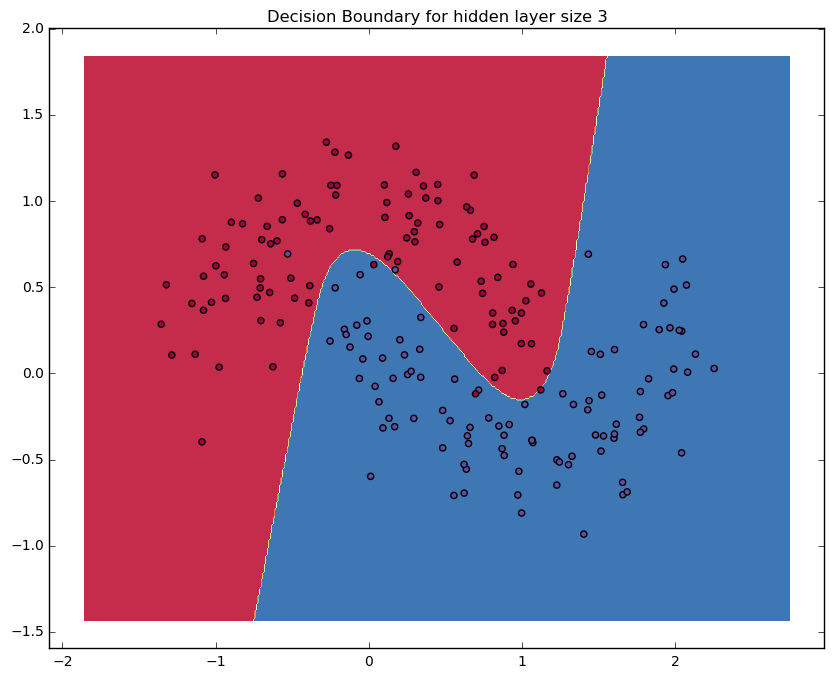

In [8]:
model = build_model(3, print_loss=True)
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

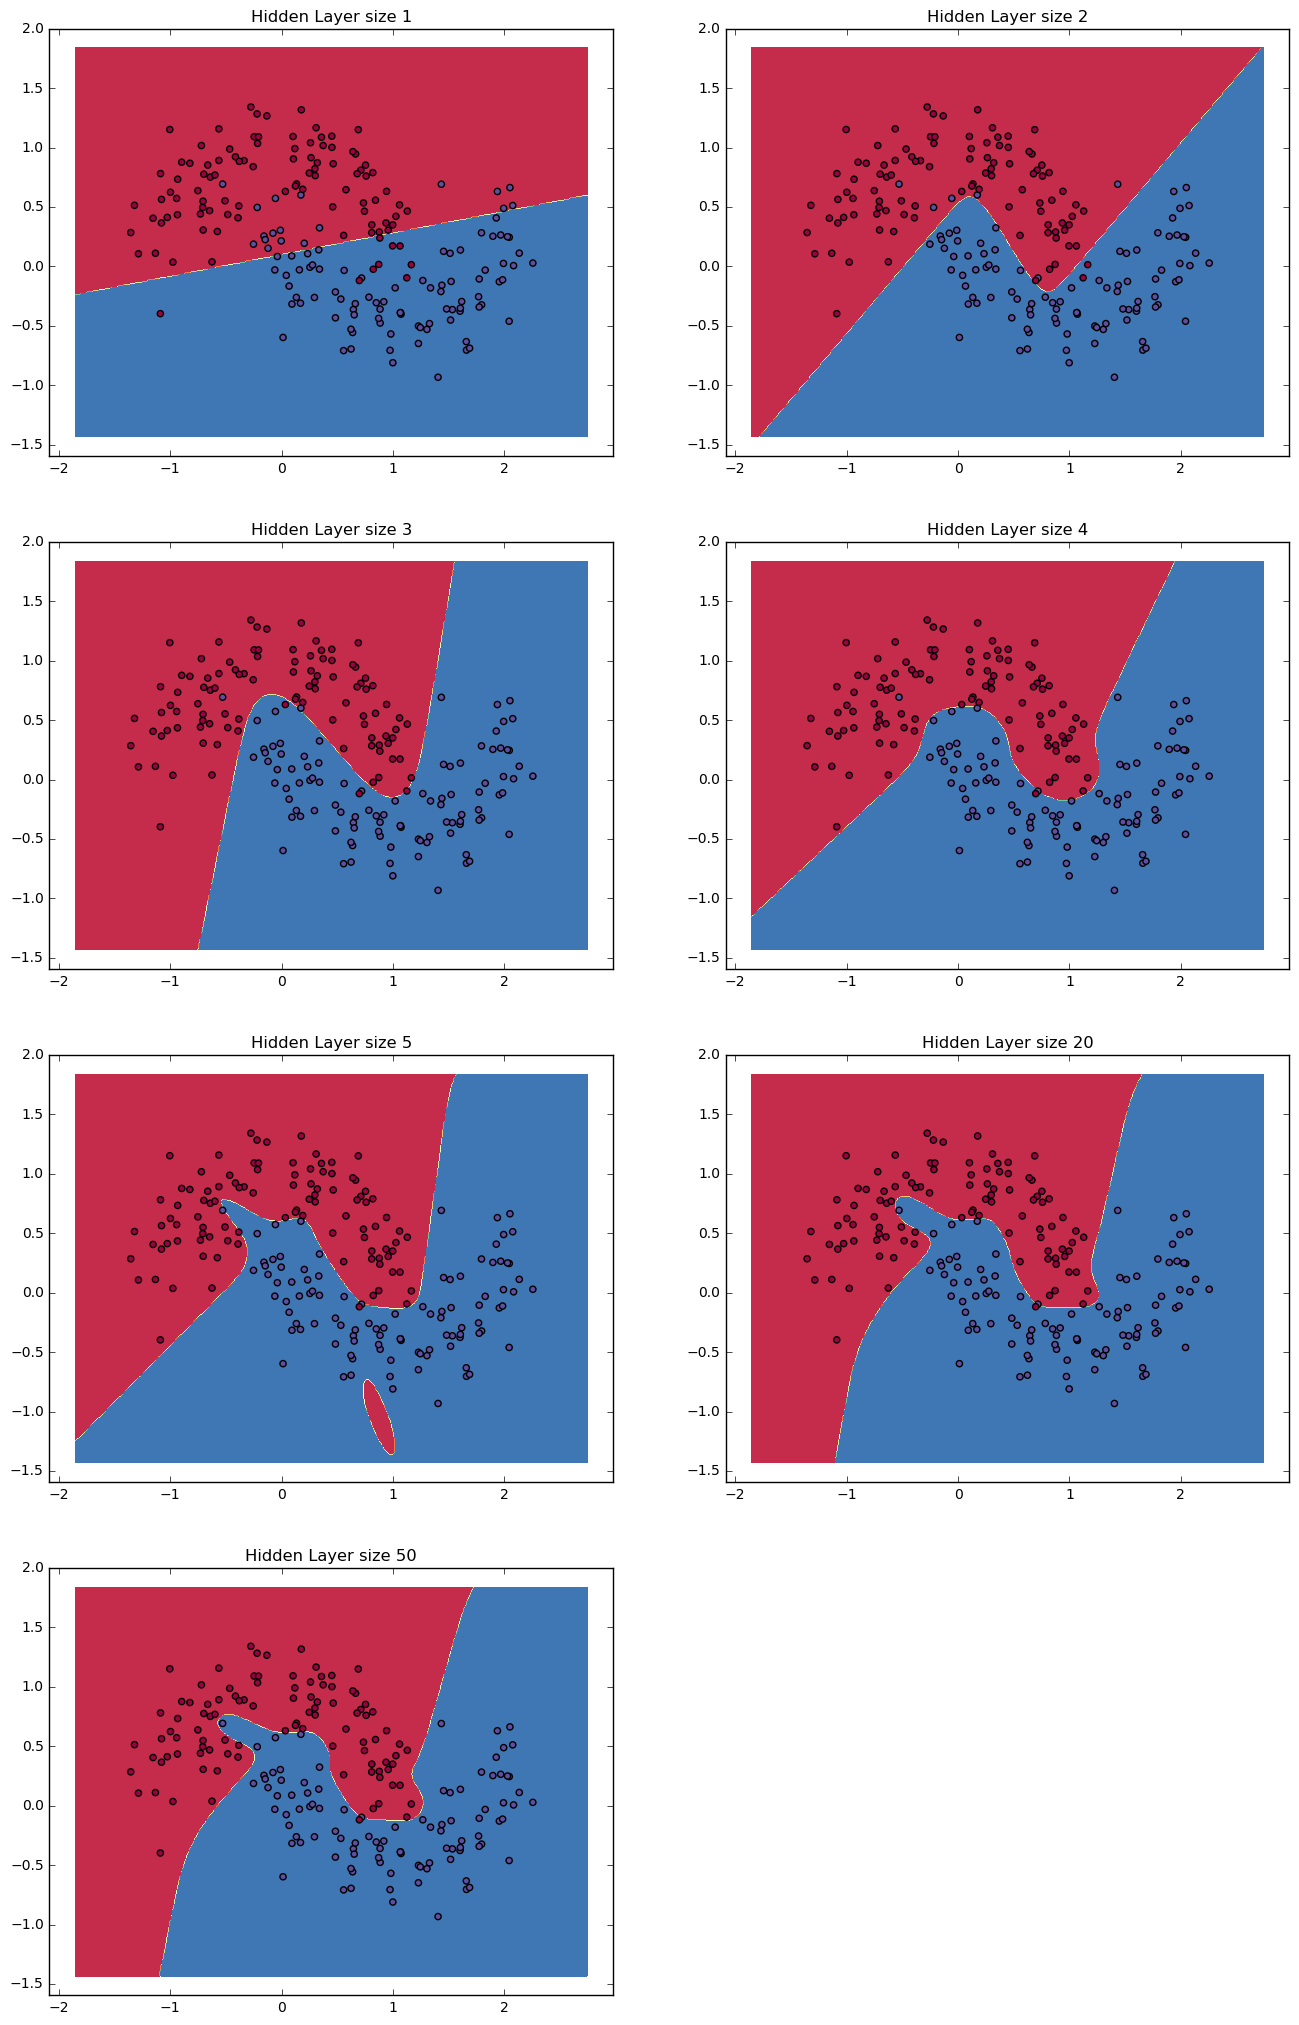

In [9]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()

Word2Vec
+ 预测一个词旁边长度为$m$的区间的词。
+ **目标函数**：给定一个$m$，最大化每个给定中心词语的上下文词的log概率，公式表示：$J(\theta)=\frac{1}{T}\sum_{t=1}^{T}\sum_{-m\leq j\leq m, j\neq 0}log\ p(w_{t+j}|w_t)$，其中$\theta$表示我们去优化的变量。
+ 对于$p(w_{t+j}|w_t)$，最简单的形式是这样的。$p(o|c)=\frac{exp(u_o^T v_c)}{\sum_{w=1}^{W}exp(u_w^T v_c)}$，其中$o$表示的是outside词，$u$表示的是outside词向量，$c$表示的是center词，$v$表示的是center词向量。
+ 每一个词有两个向量：一个是outside词向量，另一个center词向量，是要预测outsite词向量的向量，也可以叫做output词向量和input词向量。

#### 如何求解目标函数
主要利用chain rule进行求导，得到梯度。

### 词向量
#### Continuous Bag of Words Model (CBOW)
CBOW模型是为了预测一句话中缺少的那个词。比如一个句子[一 只 猫 从 楼上 了 下来]，可以预测中间缺失了"跳"这个词。

接下来，详细讨论下上面的定义。首先，我们定义已知的参数。
+ 模型的输入时一个用one-hot word vectors表示的句子，记做$x^{(c)}$
+ 模型的输出是一个one-hot vector表示的词，记做$y$
接下来我们需要定义未知的参数
+ 首先我们定义两个矩阵$\nu \in \Re^{n\times|v|}$和$\mu \in \Re^{|v |\times n}$，其中$n$是词向量的维度，$\nu$是输入的词矩阵其中第$i$列是个$n$维的词向量。同样的$\mu$是是输出的矩阵，其中第$j$列是一个$n$维的词向量。

然后我们来看这个模型是如何工作的
+ 第一步：得到以c为中心，context是m的词向量矩阵。$(v_{(c-m)},\dots,v_{(c-1)},v_{(c+1)},\dots,v_{(c+m)})$
+ 第二步：对这些词向量取平均。$\vartheta=\frac{v_{(c-m)},\dots,v_{(c-1)},v_{(c+1)},\dots,v_{(c+m)}}{2m}$
+ 第三步：得到得分向量。$z = \mu\vartheta$
+ 第四步：将得分向量变成概率。$\gamma=softmax(z)$
+ 第五步：从理想情况看，$\gamma$应该等于实际的概率$y$，且向量应该就是目标向量。

#### Skip-Gram Model
Skip-Gram和CBOW反过来，输入是center词，输出周围可能的outside词。整体思路和CBOW一样。

#### Negative Sampling
+ 利用随机负采样，来提高训练速度，和精度。
+ 具体原理是用最大似然求解2个function的max值，一个表示这个词出现在这个context的概率，一个表示这个词未出现的概率，然后得到一个新的目标函数。

## 词向量的应用
### Convolutional Neural Network (卷积神经网络)
卷积神经网络主要是应用在输入输出层都比较大的情况，通过降低参数数目和权值共享来加快训练速度和精度。

#### 局部感知
局部感知主要用来降低参数数目，认为输入层距离比较近的输入时比较相关的，距离比较远的则任务不太相关，这样每个神经元不需要接触所有的输入数据，从而降低参数数量。

#### 参数共享
在之前局部感知的时候，其实每个神经元接触到的上一层数据比较有限，但是当上一层数据依旧很多的时候，还是会导致参数很大。如果我们可以认为对于这层的每个神经元，如果上层输入参数一样，可以认为输出的参数也一样。那么我们每个神经元学习得到的特征可以使用给其他神经元用来学习。

#### 多卷积核
如果同层所有神经元的卷积核一样的话，会导致特征提取不够充分，那么我可以多选择几个卷积核。

#### down-pooling
目的是解决最终得到的特征数据量依旧很多的情况，可以通过参数公享的原理，对不同的特征按照位置进行聚合平均。

#### RNN LSTM 等，未完待续。。。